In [17]:
import numpy as np
import tensorflow
import json
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.optimizers import Adam
from glob import glob
import matplotlib.pyplot as plt
import os, shutil, random
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings
warnings.filterwarnings("ignore", message="Transparent hugepages are not enabled")

In [ ]:

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set paths
source_dir = '/content/drive/MyDrive/Solarpanel/datasets'   # original dataset
base_dir = '/content/drive/MyDrive/Solarpanel/split_dataset'  # where train/val folders will be created

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

# Function to split data
def split_data(source_dir, train_dir, val_dir, split_ratio=0.8):
    for category in os.listdir(source_dir):
        src_path = os.path.join(source_dir, category)
        if not os.path.isdir(src_path):  # skip files, only process folders
          continue

        images = os.listdir(src_path)
        random.shuffle(images)
        split = int(split_ratio * len(images))

        train_imgs = images[:split]
        val_imgs = images[split:]

        os.makedirs(os.path.join(train_dir, category), exist_ok=True)
        os.makedirs(os.path.join(val_dir, category), exist_ok=True)

        # Copy training images
        for img in train_imgs:
            shutil.copy(os.path.join(src_path, img),
                        os.path.join(train_dir, category, img))

        # Copy validation images
        for img in val_imgs:
            shutil.copy(os.path.join(src_path, img),
                        os.path.join(val_dir, category, img))

# Run the split
split_data(source_dir, train_dir, val_dir)

print("Data successfully split into train and validation folders !")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data successfully split into train and validation folders !


In [ ]:
train_path = '/content/drive/MyDrive/Solarpanel/split_dataset/train'
valid_path = '/content/drive/MyDrive/Solarpanel/split_dataset/val'

In [ ]:
input_tensor = Input(shape=(224, 224, 3))

vgg16 = VGG16(input_tensor=input_tensor,
      weights = 'imagenet',
      include_top = False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
# Freezing the layers in base model VGG16
for layer in vgg16.layers:
    layer.trainable = False

for layer in vgg16.layers:
  print(layer.name, layer.trainable)

input_layer False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False


In [ ]:
vgg16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
folder = glob('/content/drive/MyDrive/Solarpanel/split_dataset/train/*')
len(folder)

6

In [ ]:
# model = Sequential([
#     vgg16,
#     Flatten(),
#     Dense(256, activation='relu'),
#     Dropout(0.5),
#     Dense(6, activation='softmax')  # 6 classes
# ])

x = Flatten()(vgg16.output)
x = Dense(256, activation='relu')(x)
output_tensor = Dense(6, activation='softmax')(x)

model = Model(inputs= vgg16.input, outputs=output_tensor)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,139,014 (80.64 MB)

 Trainable params: 6,424,326 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
train_dir = '/content/drive/MyDrive/Solarpanel/split_dataset/train'
val_dir = '/content/drive/MyDrive/Solarpanel/split_dataset/val'

# Image preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)


Found 692 images belonging to 6 classes.
Found 177 images belonging to 6 classes.


In [18]:
with open('class_indices.json', 'w') as f:
    json.dump(train_data.class_indices, f)

In [ ]:
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Solarpanel/checkpoints/vgg16_best.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,          # stops if no improvement for 5 epochs
    restore_best_weights=True,
    verbose=1
)


In [ ]:
# Training the Model

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs = 20,
    steps_per_epoch = len(train_data),
    validation_steps = len(val_data),
    callbacks=[checkpoint, early_stop]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.3051 - loss: 1.7302 

22/22 ━━━━━━━━━━━━━━━━━━━━ 608s 27s/step - accuracy: 0.3092 - loss: 1.7199 - val_accuracy: 0.5537 - val_loss: 1.0986
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.5953 - loss: 1.0625 

22/22 ━━━━━━━━━━━━━━━━━━━━ 526s 24s/step - accuracy: 0.5967 - loss: 1.0600 - val_accuracy: 0.5876 - val_loss: 1.0595
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.6753 - loss: 0.9490 

22/22 ━━━━━━━━━━━━━━━━━━━━ 512s 23s/step - accuracy: 0.6763 - loss: 0.9457 - val_accuracy: 0.7175 - val_loss: 0.8811
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 507s 23s/step - accuracy: 0.6958 - loss: 0.8304 - val_accuracy: 0.6893 - val_loss: 0.8826
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.7621 - loss: 0.7295 

22/22 ━━━━━━━━━━━━━━━━━━━━ 501s 23s/step - accuracy: 0.7632 - loss: 0.7261 - val_accuracy: 0.7288 - val_loss: 0.8133
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.8174 - loss: 0.5675 

22/22 ━━━━━━━━━━━━━━━━━━━━ 546s 25s/step - accuracy: 0.8167 - loss: 0.5682 - val_accuracy: 0.7401 - val_loss: 0.7760
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.8171 - loss: 0.5554 

22/22 ━━━━━━━━━━━━━━━━━━━━ 506s 23s/step - accuracy: 0.8168 - loss: 0.5555 - val_accuracy: 0.7627 - val_loss: 0.7326
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.8483 - loss: 0.4751 

22/22 ━━━━━━━━━━━━━━━━━━━━ 501s 23s/step - accuracy: 0.8477 - loss: 0.4757 - val_accuracy: 0.7740 - val_loss: 0.7812
Epoch 9/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 500s 23s/step - accuracy: 0.8347 - loss: 0.4891 - val_accuracy: 0.7684 - val_loss: 0.7225
Epoch 10/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 500s 23s/step - accuracy: 0.8846 - loss: 0.4118 - val_accuracy: 0.7627 - val_loss: 0.7076
Epoch 11/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 500s 23s/step - accuracy: 0.8801 - loss: 0.3864 - val_accuracy: 0.7684 - val_loss: 0.7104
Epoch 12/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 508s 23s/step - accuracy: 0.8822 - loss: 0.3497 - val_accuracy: 0.7401 - val_loss: 0.7612
Epoch 13/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.8748 - loss: 0.3451 

22/22 ━━━━━━━━━━━━━━━━━━━━ 560s 23s/step - accuracy: 0.8747 - loss: 0.3453 - val_accuracy: 0.7797 - val_loss: 0.6969
Epoch 14/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9189 - loss: 0.2920 

22/22 ━━━━━━━━━━━━━━━━━━━━ 516s 23s/step - accuracy: 0.9181 - loss: 0.2935 - val_accuracy: 0.7910 - val_loss: 0.6970
Epoch 15/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9204 - loss: 0.2854 

22/22 ━━━━━━━━━━━━━━━━━━━━ 505s 23s/step - accuracy: 0.9198 - loss: 0.2861 - val_accuracy: 0.7966 - val_loss: 0.6723
Epoch 16/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 500s 23s/step - accuracy: 0.9517 - loss: 0.2484 - val_accuracy: 0.7797 - val_loss: 0.6866
Epoch 17/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 503s 23s/step - accuracy: 0.9045 - loss: 0.2845 - val_accuracy: 0.7797 - val_loss: 0.6773
Epoch 18/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 502s 23s/step - accuracy: 0.9464 - loss: 0.2346 - val_accuracy: 0.7853 - val_loss: 0.7215
Epoch 19/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 494s 23s/step - accuracy: 0.9301 - loss: 0.2439 - val_accuracy: 0.7740 - val_loss: 0.7262
Epoch 20/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 494s 22s/step - accuracy: 0.9264 - loss: 0.2399 - val_accuracy: 0.7684 - val_loss: 0.7179
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 15.


In [13]:
# Prediction of a image

# Path to a test image from Drive
img_path = '/content/drive/MyDrive/Solarpanel/Bird (2).JPG'

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Predict
pred = model.predict(img_array)
class_idx = np.argmax(pred, axis=1)[0]
class_label = list(train_data.class_indices.keys())[class_idx]

print(f"Predicted class: {class_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted class: Bird-drop


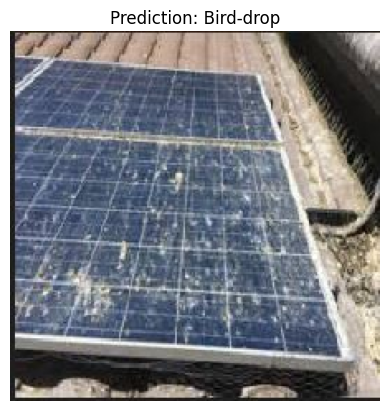

In [14]:
# Visualize Prediction
plt.imshow(img)
plt.title(f"Prediction: {class_label}")
plt.axis('off')
plt.show()

In [16]:
model.save('/content/drive/MyDrive/Solarpanel/vgg16_solarpanel_model.h5')